In [152]:
import numpy as np
import pandas as pd
from os import listdir
from scipy.stats import linregress
from matplotlib import pyplot as plt
from uncertainties import ufloat

plt.style.use('seaborn-v0_8')

In [89]:
!ls

AuCu_1_423	   cfg_3_623	    mlip.ini		  msd_gold_4_623.out
AuCu_1_523	   cfg_3_723	    msd_copper_1_423.out  msd_gold_4_723.out
AuCu_1_623	   cfg_4_423	    msd_copper_1_523.out  msd_gold_5_423.out
AuCu_1_723	   cfg_4_523	    msd_copper_1_623.out  msd_gold_5_523.out
AuCu_2_423	   cfg_4_623	    msd_copper_1_723.out  msd_gold_5_623.out
AuCu_2_523	   cfg_4_723	    msd_copper_2_423.out  msd_gold_5_723.out
AuCu_2_623	   cfg_5_423	    msd_copper_2_523.out  run_lmp.sh
AuCu_2_723	   cfg_5_523	    msd_copper_2_623.out  run_multi_lmp.sh
AuCu_3_423	   cfg_5_623	    msd_copper_2_723.out  run_server.sh
AuCu_3_523	   cfg_5_723	    msd_copper_3_423.out  slurm-28474254_0.out
AuCu_3_623	   dump.AuCu_0_523  msd_copper_3_523.out  slurm-28474254_1.out
AuCu_3_723	   dump.AuCu_1_423  msd_copper_3_623.out  slurm-28474254_2.out
AuCu_4_423	   dump.AuCu_1_523  msd_copper_3_723.out  slurm-28474254_3.out
AuCu_4_523	   dump.AuCu_1_623  msd_copper_4_423.out  slurm-28474254_4.out
AuCu_4_623	   dump.AuCu_1_723  msd_co

In [184]:
msd_files = sorted([x for x in listdir() if '.out' in x and 'gold' in x], key=lambda x: x.split('_')[2])
T_array = [int(x.replace('.out', '').split('_')[-1]) for x in listdir() if '.out' in x and 'gold' in x] 
T_array = np.sort(np.unique_all(T_array)[0])
T_array, msd_files

(array([423, 523, 623, 723]),
 ['msd_gold_1_723.out',
  'msd_gold_1_523.out',
  'msd_gold_1_423.out',
  'msd_gold_1_623.out',
  'msd_gold_2_723.out',
  'msd_gold_2_623.out',
  'msd_gold_2_423.out',
  'msd_gold_2_523.out',
  'msd_gold_3_423.out',
  'msd_gold_3_723.out',
  'msd_gold_3_623.out',
  'msd_gold_3_523.out',
  'msd_gold_4_723.out',
  'msd_gold_4_623.out',
  'msd_gold_4_423.out',
  'msd_gold_4_523.out',
  'msd_gold_5_623.out',
  'msd_gold_5_723.out',
  'msd_gold_5_423.out',
  'msd_gold_5_523.out'])

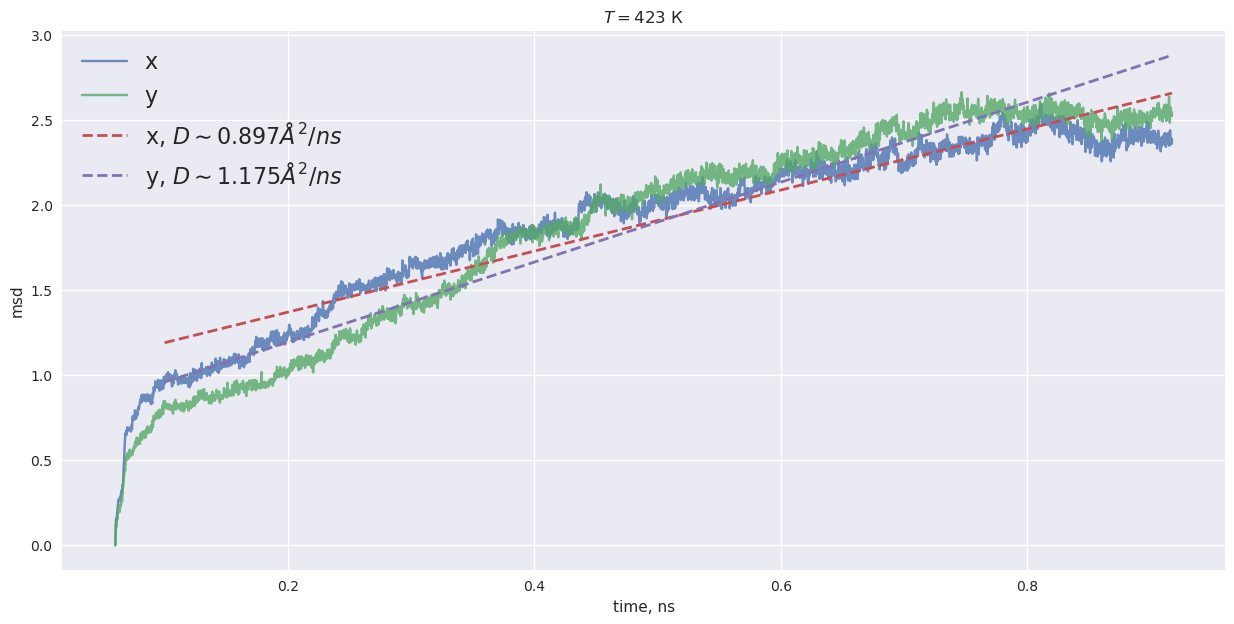

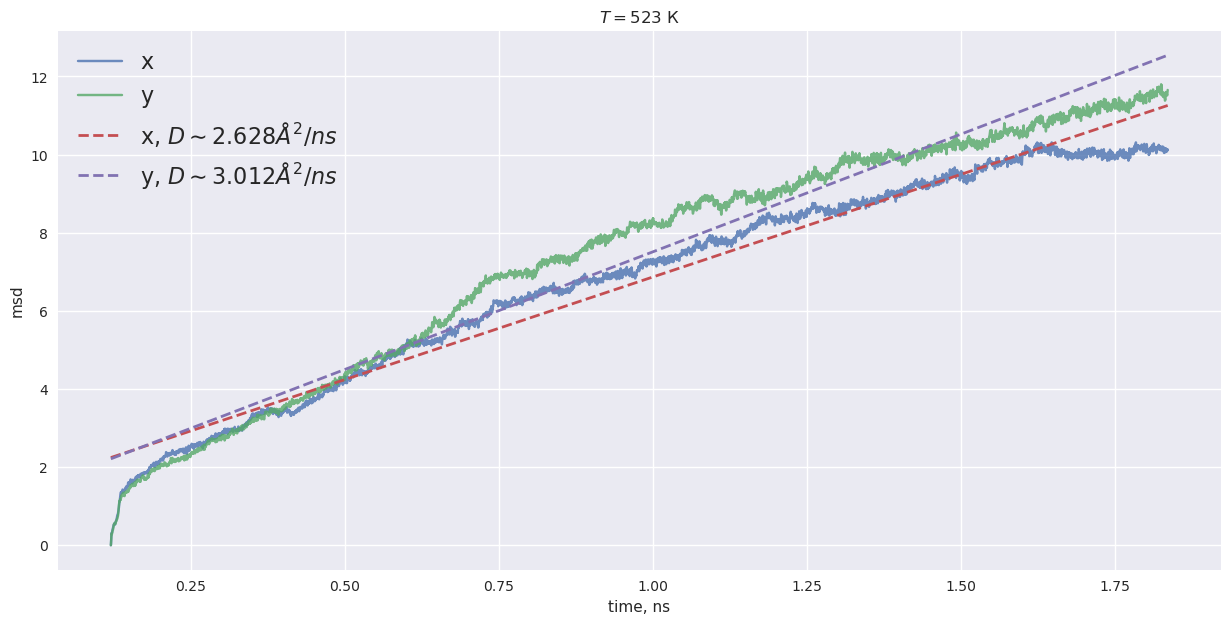

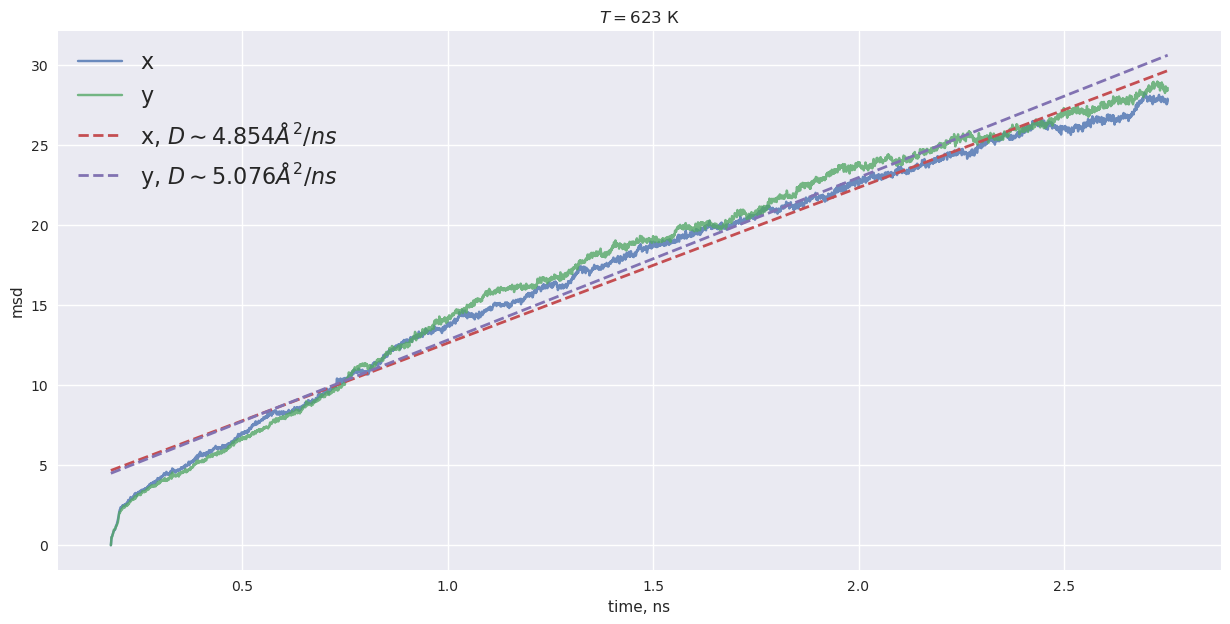

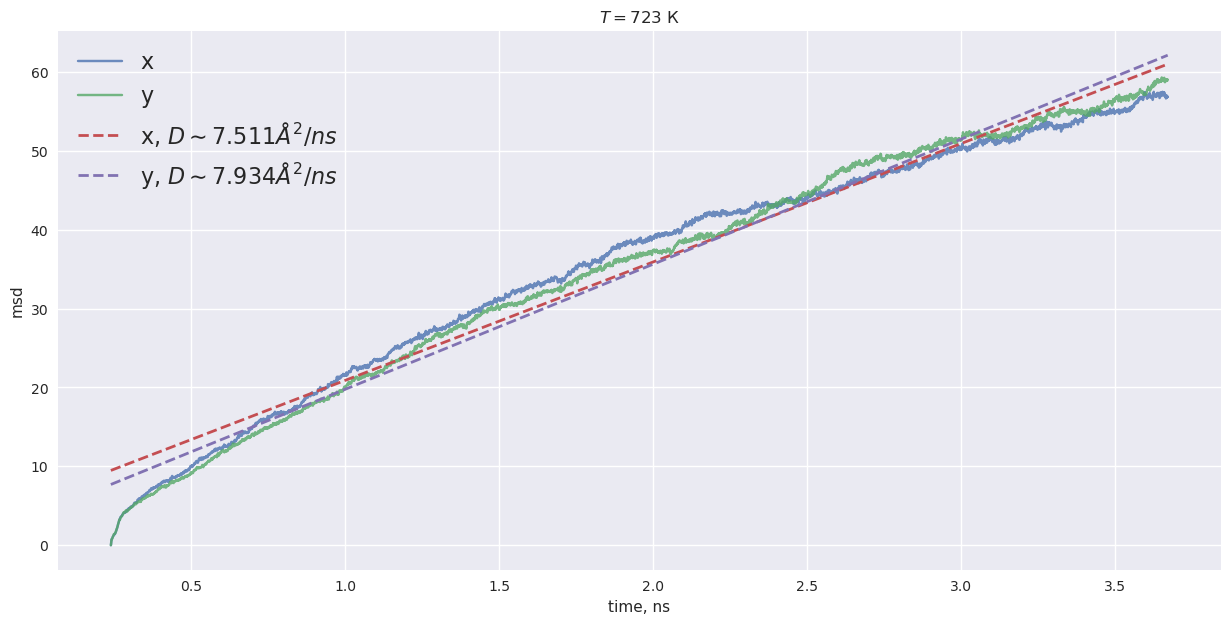

In [188]:

datas = []
D = []

for T in T_array:
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set_title(f'$T = {T}$ К')
    files = [x for x in msd_files if str(T) in x]
    for file in files:
        T = file.replace('.out', '').split('_')[-1]
        # print(file.split('_'))
        s = int(file.split('_')[2]) - 1
        
        data = pd.read_csv(file, skiprows=1, sep=' ', escapechar='#')
        datas.append(data)
        
    mean_data = (sum(datas) / (s + 1)).dropna()
    time = mean_data[' TimeStep'].astype(int) / 1e6


    ax.plot(time, mean_data['c_msd_gold[1]'], label='x', alpha=0.8)
    ax.plot(time, mean_data['c_msd_gold[2]'], label='y', alpha=0.8)
    # ax.plot(time, mean_data['c_msd_gold[3]'], label='z', alpha=0.8)
    ax.set_xlabel('time, ns')
    ax.set_ylabel('msd')
    mask = time >= 0.1


    resx = linregress(time[mask], mean_data['c_msd_gold[1]'][mask])
    resy = linregress(time[mask], mean_data['c_msd_gold[2]'][mask])

    # Dx.append(resx.slope / 2)
    # Dy.append(resy.slope / 2)
    D.append((resx.slope + resy.slope) / 4)
    ax.plot(time[mask], time[mask] * resx.slope + resx.intercept, label=f'x, $D \\sim {resx.slope / 2:.3f}  \\AA^2/ns$', linestyle='--', linewidth=2)
    ax.plot(time[mask], time[mask] * resy.slope + resy.intercept, label=f'y, $D \\sim {resy.slope / 2:.3f}  \\AA^2/ns$', linestyle='--', linewidth=2)

    ax.legend(fontsize=16);

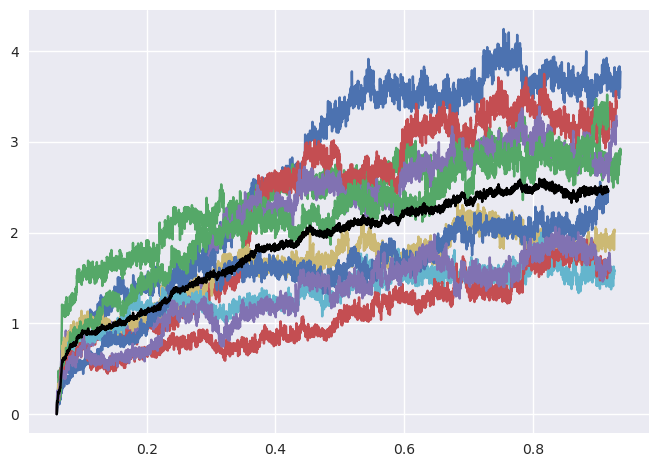

In [187]:
for data in datas:
    
    plt.plot(data[' TimeStep'] * 1e-6, data['c_msd_gold[2]'])
    plt.plot(data[' TimeStep'] * 1e-6, data['c_msd_gold[1]'])
    
plt.plot(mean_data[' TimeStep'] * 1e-6, (mean_data['c_msd_gold[1]'] + mean_data['c_msd_gold[2]']) / 2, c='k')

(LinregressResult(slope=np.float64(-2039.1735198688793), intercept=np.float64(4.8830501151402945), rvalue=np.float64(-0.9991389849703649), pvalue=np.float64(0.0008610150296350925), stderr=np.float64(59.87425747529686), intercept_stderr=np.float64(0.11094616135964248)),
 16.954632002877762+/-0.49782227556803793)

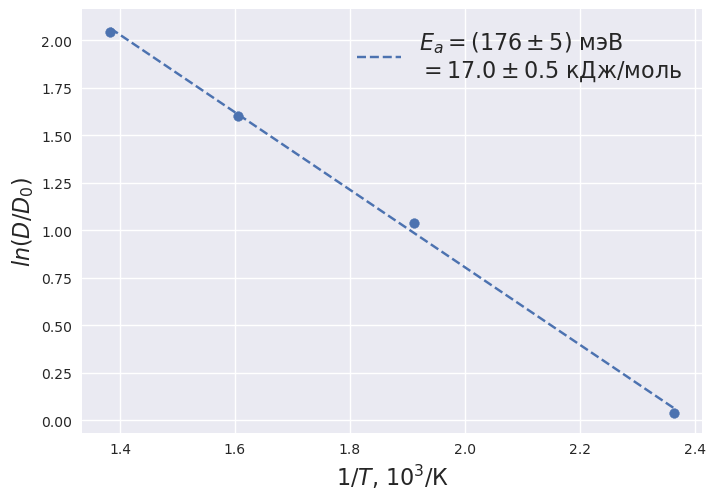

In [205]:
from scipy.constants import k, e, N_A



D = np.array(D)
X = 1 / T_array
Y = np.log(D)


fig, ax = plt.subplots()
plt.scatter(X *1e3, Y)

res = linregress(X, Y)
grid = np.linspace(X.min(), X.max())
plt.xlabel('$1 / T$, $10^3$/К', fontsize=16)
plt.ylabel('$ln (D / D_0)$', fontsize=16)

E_activation = - ufloat(res.slope, res.stderr) * k / e * 1e3
plt.plot(grid * 1e3, grid * res.slope + res.intercept, linestyle='--', label=f'$E_a = ({E_activation.nominal_value:.0f} \\pm {E_activation.std_dev:.0f}$) мэВ\n$={E_activation.nominal_value * e * N_A / 1e6:.1f} \\pm {E_activation.std_dev * e * N_A / 1e6:.1f}$ кДж/моль')
# plt.xscale()
plt.legend(fontsize=16)
# plt.twiny()
# plt.set_xtickslabels(T_array)
res, E_activation * e * N_A / 1e6


In [93]:
import numpy as np

with open('dump.AuCu_1_523') as f:
    lines = f.readlines()
    pos = []
    minipos = []
    read_atoms = False
    add_time_step = False
    gtime = []
    
    for line in lines:
        if line.startswith("ITEM: ATOMS"):
            headers = line.split()[2:]  # Сохраняем заголовки для поиска индекса типа атома
            type_index = headers.index("type")  # Определяем индекс колонки типа атома
            x_index = headers.index("xs")
            y_index = headers.index("ys")
            z_index = headers.index("zs")
            read_atoms = True
            continue
        
        if add_time_step:
            gtime.append(int(line))
            add_time_step = False
        
        if line.startswith("ITEM: TIMESTEP"):
            add_time_step = True
            if read_atoms:
                read_atoms = False
                pos.append(minipos)
                minipos = []
                continue
        
        if read_atoms:
            if line.strip():
                parts = line.split()
                atom_type = int(parts[type_index])
                if atom_type == 2:  # Фильтруем только атомы типа 2
                    minipos.append((float(parts[x_index]), float(parts[y_index]), float(parts[z_index])))

pos = np.array(pos[200:])
gtime = np.array(gtime)[200:] * 1e-6
pos.shape


(860, 121, 3)

In [94]:
def msd(data, step_len, shift, axis=None):
    msd = []
    n = 0
    if axis == None:
        for step in range(0, len(data) - step_len, shift):
            msd.append(((data[step:step+step_len, :, :3] - data[:, :, :3][step]) ** 2).sum(axis=2).mean(axis=1))
    else:
        for step in range(0, len(data) - step_len, shift):
            n+=1
            msd.append(((data[step:step+step_len, :, axis] - data[:, :, axis][step]) ** 2).mean(axis=1))
        print(f"Took {n} steps")
    msd = np.array(msd).mean(axis=0)
    return msd

def diffusion(data, step_len, shift, axis=None):
    D = []
    n = 0
    if axis == None:
        for step in range(0, len(data) - step_len, shift):
            msd_cut = ((data[step:step+step_len, :, :3] - data[:, :, :3][step]) ** 2).sum(axis=2).mean(axis=1)
            res = linregress(gtime[10:step_len], msd_cut[10:])
            D.append(res.slope)
        D = np.array(D) / 6
    else:
        for step in range(0, len(data) - step_len, shift):
            n+=1
            msd_cut = ((data[step:step+step_len, :, axis] - data[:, :, axis][step]) ** 2).mean(axis=1)
            res = linregress(gtime[10:step_len], msd_cut[10:])
            D.append(res.slope)
        D = np.array(D) / 2
        # print(f"Took {n} steps")
    return D
    

Took 1 steps
Took 1 steps


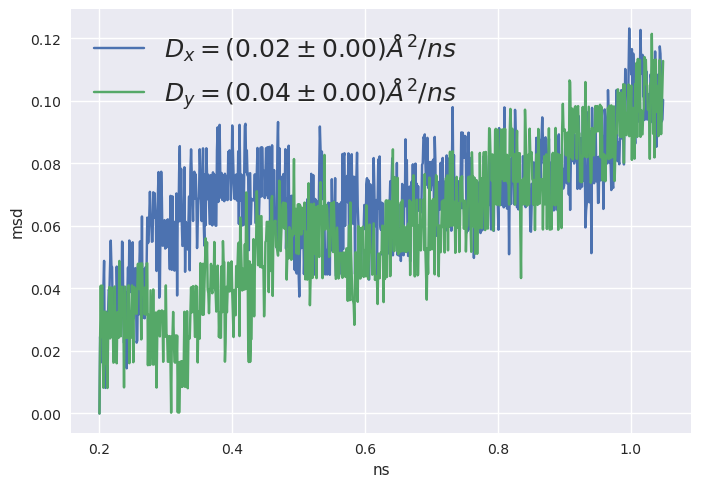

In [97]:
step_len = 850
shift = 10

msdx = msd(pos, shift=shift, step_len=step_len, axis=0)
Dx = diffusion(pos, shift=shift, step_len=step_len, axis=0)
msdy = msd(pos, shift=shift, step_len=step_len, axis=1)
Dy = diffusion(pos, shift=shift, step_len=step_len, axis=1)
plt.plot(gtime[:step_len], msdx, label=rf'$D_x = ({Dx.mean():.2f} \pm {Dx.std():.2f}) \AA ^2 / ns$')
plt.plot(gtime[:step_len], msdy, label=rf'$D_y = ({Dy.mean():.2f} \pm {Dy.std():.2f}) \AA ^2 / ns$')
plt.xlabel('ns')
plt.ylabel('msd')
plt.legend(fontsize=18);